In [35]:
import pandas as pd
import numpy as np
import os

# import time
import multiprocessing as mp
import glob
import sys  
sys.path.insert(0, '../')

from test_library     import  plot_confusion_matrix_2fractions, plot_Feature_Importance_withSTD, class_train_model_and_classify
from muwclass_library import plot_confusion_matrix,plot_confusion_matrix_diff,class_prepare, class_train_and_classify, class_save_res, col_rename, confident_flag, confident_sigma, find_confident, plot_classifier_matrix_withSTD, prepare_cols
from other_libaray import prepare_field, dict_update, combine_class_result, plot_bbsed, plot_class_matrix, prepare_evts_plot_xray_class, interactive_Ximg_class, CMweight_probability


from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef
#from muwclass_library import loo_prepare, loo_train_and_classify, loo_save_res, plot_confusion_matrix,  confident_flag, confident_sigma
from bokeh.io import show
from bokeh.layouts import row
from bokeh.io import export_png
from sklearn.metrics import confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt

# No Physical oversampling and Physical Oversampling

In [27]:
dir_data = '/Volumes/PoplarII/Projects/2019/MUWCLASS_Project/ML/DATA/MUWCLASS_Classify_evaluation'
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']
#for test, title in zip(['test_TDv11162022'], ['CM_TDv11162022']):  
#for test, title in zip(['test_TDv11162022', 'test_TDv11162022_physicaloversample'], ['CM_TDv11162022','physicaloversample']):  
#for test, title in zip(['test_TDv11162022_physicaloversample'], ['physicaloversample']):  
#for test, title in zip(['test_TDv11162022_physicaloversample_ebv3'], ['physicaloversample_ebv3']): 
for test, title in zip(['test_TDv11162022_physicaloversample_gamma'], ['physicaloversample_gamma']): 
    #'''
    files = glob.glob(f'{dir_data}/LOO_{test}_results/*/classes.csv')
    dfs = [pd.read_csv(f, usecols=range(len(class_labels))) for f in files]
    print(len(dfs))
    df_median   = pd.concat(dfs).groupby(level=0).median()
    #df_1sig_up  = pd.concat(dfs).groupby(level=0).quantile(0.84135)
    #df_1sig_low = pd.concat(dfs).groupby(level=0).quantile(0.15865)
    df_2sig_up  = pd.concat(dfs).groupby(level=0).quantile(0.97725)
    df_2sig_low = pd.concat(dfs).groupby(level=0).quantile(0.02275)
    df_mean     = pd.concat(dfs).groupby(level=0).mean()
    df_std      = pd.concat(dfs).groupby(level=0).std()


    df_class = df_median.idxmax(axis=1)
    df_prob = df_median.max(axis=1)
    #df_prob_1sig_up  = pd.DataFrame(data=[df_1sig_up.values[i][np.argmax(np.array(df_median), axis=1)[i]]  for i in range(len(df_median))], columns=['Class_prob_1sig_upp'])
    #df_prob_1sig_low = pd.DataFrame(data=[df_1sig_low.values[i][np.argmax(np.array(df_median), axis=1)[i]]  for i in range(len(df_median))], columns=['Class_prob_1sig_low'])
    df_prob_2sig_up  = pd.DataFrame(data=[df_2sig_up.values[i][np.argmax(np.array(df_median), axis=1)[i]]  for i in range(len(df_median))], columns=['Class_prob_2sig_upp'])
    df_prob_2sig_low = pd.DataFrame(data=[df_2sig_low.values[i][np.argmax(np.array(df_median), axis=1)[i]]  for i in range(len(df_median))], columns=['Class_prob_2sig_low'])
    df_class_mean = df_mean.idxmax(axis=1)
    df_prob_mean = df_mean.max(axis=1)
    df_prob_e = pd.DataFrame(data=[df_std.values[i][np.argmax(np.array(df_mean), axis=1)[i]]  for i in range(len(df_std))], columns=['Class_prob_e'])

    df_mean = df_mean.add_prefix('P_')
    df_std  = df_std.add_prefix('e_P_')
    df_median = df_median.add_prefix('P_median_')
    df_2sig_up = df_2sig_up.add_prefix('P_2sig_upp_')
    df_2sig_low = df_2sig_low.add_prefix('P_2sig_low_')

    df = pd.concat([df_median, df_2sig_up, df_2sig_low, df_mean, df_std, df_class, df_prob, df_prob_2sig_up, df_prob_2sig_low, df_class_mean, df_prob_mean, df_prob_e, pd.read_csv(files[0]).name, pd.read_csv(files[0]).true_Class],axis=1).rename(columns={0:'Class_median',1:'Class_prob_median',2:'Class',3:'Class_prob'})
    #print(df.columns)
   
    df_default = confident_flag(df, method = 'sigma-mean', class_cols=class_labels)
    df_default = confident_sigma(df, class_cols=class_labels)
    df_default.to_csv(f'{dir_data}/LOO_{test}_results/LOO_classes.csv',index=False)
    '''  
    df_default = pd.read_csv(f'{dir_data}/LOO_{test}_results/LOO_classes.csv')

    print('accuracy for all classifications:',accuracy_score(df_default.true_Class, df_default.Class))
    print('accuracy for confident classifications:',accuracy_score(df_default.loc[df_default.conf_flag>0, 'true_Class'], df_default.loc[df_default.conf_flag>0, 'Class']))
    print('balanced accuracy for all classifications:',balanced_accuracy_score(df_default.true_Class, df_default.Class))
    print('balanced accuracy for confident classifications:',balanced_accuracy_score(df_default.loc[df_default.conf_flag>0, 'true_Class'], df_default.loc[df_default.conf_flag>0, 'Class']))
   
   
   
    CM = plot_confusion_matrix(df_default, title=f'recall {title}',classes=class_labels)
    #show(CM)
    conf_CM = plot_confusion_matrix(df_default[df_default.conf_flag>0], title=f'confident recall {title}',classes=class_labels,count_fraction=True,df_all = df_default)
    CM_p = plot_confusion_matrix(df_default, title=f'precision {title}',classes=class_labels,cm_type='precision')
    
    conf_CM_p = plot_confusion_matrix(df_default[df_default.conf_flag>0], title=f'confident precision {title}',classes=class_labels,cm_type='precision',count_fraction=True,df_all = df_default)
    show(row(CM,conf_CM))
    show(row(CM_p, conf_CM_p))
    export_png(CM, filename=f'./figs/{title}.png')
    export_png(conf_CM, filename=f'./figs/{title}_conf.png')
    export_png(CM_p, filename=f'./figs/{title}_precision.png')
    export_png(conf_CM_p, filename=f'./figs/{title}_conf_precision.png')
    '''  

100


# Physcial oversampling difference


In [37]:
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']

df_base = pd.read_csv(f'data/LOO_test_TDv11162022_results/LOO_classes.csv')

df1 = pd.read_csv(f'data/LOO_test_TDv11162022_physicaloversample_results/LOO_classes.csv')
df1 = df1.iloc[0::101, :]
df2 = pd.read_csv(f'data/LOO_test_TDv11162022_physicaloversample_ebv3_results/LOO_classes.csv')
df2 = df2.iloc[0::4, :]
df3 = pd.read_csv(f'data/LOO_test_TDv11162022_physicaloversample_gamma_results/LOO_classes.csv')
df3 = df3.iloc[0::4, :]

for df, title in zip([df1,df2,df3],['uniform10_dif','uniform3_dif','gamma_dif']):
    CM = plot_confusion_matrix_diff(df_base, df,  title=f'recall {title}',classes=class_labels)
    conf_CM = plot_confusion_matrix_diff(df_base[df_base.CT>=2], df[df.CT>=2],title=f'confident recall {title}',classes=class_labels)
    show(row(CM,conf_CM))
    CM_p = plot_confusion_matrix_diff(df_base, df, title=f'precision {title}',classes=class_labels,cm_type='precision')
    conf_CM_p = plot_confusion_matrix_diff(df_base[df_base.CT>=2], df[df.CT>=2], title=f'confident precision {title}',classes=class_labels,cm_type='precision')
    show(row(CM_p, conf_CM_p))
    export_png(CM, filename=f'./figs/{title}.png')
    export_png(conf_CM, filename=f'./figs/{title}_conf.png')
    export_png(CM_p, filename=f'./figs/{title}_precision.png')
    export_png(conf_CM_p, filename=f'./figs/{title}_conf_precision.png')

## Evaluation of all sources from the TD (calculating performance metrics, confusion matrices)

class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']
title= 'CM'
    
df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_results/0/classes.csv')


print('accuracy for all classifications:',accuracy_score(df_default.true_Class, df_default.Class))
print('accuracy for confident classifications:',accuracy_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
print('balanced accuracy for all classifications:',balanced_accuracy_score(df_default.true_Class, df_default.Class))
print('balanced accuracy for confident classifications:',balanced_accuracy_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
print('f1_score for all classifications:',f1_score(df_default.true_Class, df_default.Class, average='macro'))
print('f1_score for confident classifications:',f1_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class'], average='macro'))
print(f'MCC:{matthews_corrcoef(df_default.true_Class, df_default.Class)}')
print('MCC conf:',matthews_corrcoef(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
print('completeness:',len(df_default.loc[df_default.CT>=2])/len(df_default))
class_completeness = [len(df_default.loc[(df_default.CT>=2) & (df_default.true_Class==c)]) /len(df_default.loc[(df_default.true_Class==c)]) for c in class_labels ]
print('balanced completeness:',np.mean(class_completeness))


CM = plot_confusion_matrix(df_default, title=f'recall {title}',classes=class_labels)
conf_CM = plot_confusion_matrix(df_default[df_default.CT>=2], title=f'confident recall {title}',classes=class_labels,count_fraction=True,df_all = df_default)
show(row(CM,conf_CM))
CM_p = plot_confusion_matrix(df_default, title=f'precision {title}',classes=class_labels,cm_type='precision')
conf_CM_p = plot_confusion_matrix(df_default[df_default.CT>=2], title=f'confident precision {title}',classes=class_labels,cm_type='precision',count_fraction=True,df_all = df_default)
show(row(CM_p, conf_CM_p))

export_png(CM, filename=f'./figures/{title}.png')
export_png(conf_CM, filename=f'./figures/{title}_conf.png')
export_png(CM_p, filename=f'./figures/{title}_precision.png')
export_png(conf_CM_p, filename=f'./figures/{title}_conf_precision.png')

In [3]:
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']
title= 'CM'
    
df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_results/0/classes.csv')
#df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_results/LOO_classes.csv')

for jj in range(0,101,50):
    df = df_default.iloc[jj::101, :]
    print('accuracy for all classifications:',accuracy_score(df.true_Class, df.Class))
    #print('accuracy for confident classifications:',accuracy_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
    print('balanced accuracy for all classifications:',balanced_accuracy_score(df.true_Class, df.Class))
    #print('balanced accuracy for confident classifications:',balanced_accuracy_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
    print('f1_score for all classifications:',f1_score(df.true_Class, df.Class, average='macro'))
    #print('f1_score for confident classifications:',f1_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class'], average='macro'))
    print(f'MCC:{matthews_corrcoef(df.true_Class, df.Class)}')
    #print('MCC conf:',matthews_corrcoef(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
    #print('completeness:',len(df_default.loc[df_default.CT>=2])/len(df_default))
    #class_completeness = [len(df_default.loc[(df_default.CT>=2) & (df_default.true_Class==c)]) /len(df_default.loc[(df_default.true_Class==c)]) for c in class_labels ]
    #print('balanced completeness:',np.mean(class_completeness))


    CM = plot_confusion_matrix(df, title=f'recall {title}',classes=class_labels)
    #conf_CM = plot_confusion_matrix(df_default[df_default.CT>=2], title=f'confident recall {title}',classes=class_labels,count_fraction=True,df_all = df_default)
    #show(row(CM,conf_CM))
    CM_p = plot_confusion_matrix(df, title=f'precision {title}',classes=class_labels,cm_type='precision')
    #conf_CM_p = plot_confusion_matrix(df_default[df_default.CT>=2], title=f'confident precision {title}',classes=class_labels,cm_type='precision',count_fraction=True,df_all = df_default)
    #show(row(CM_p, conf_CM_p))
    show(row(CM,CM_p))


accuracy for all classifications: 0.8939247830279653
balanced accuracy for all classifications: 0.6623618069517958
f1_score for all classifications: 0.6671582742108436
MCC:0.8490911103528633


accuracy for all classifications: 0.6579877852780457
balanced accuracy for all classifications: 0.6072037998711752
f1_score for all classifications: 0.49938573595984415
MCC:0.5922993619036676


accuracy for all classifications: 0.47669559627129543
balanced accuracy for all classifications: 0.5411785650319774
f1_score for all classifications: 0.36922294465001326
MCC:0.43214006452633824


In [32]:
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']
title= 'CM'
    
#df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_results/0/classes.csv')

#df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_ebv3_results/LOO_classes.csv')
#title = 'physicaloversample_uniform3'

df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_gamma_results/LOO_classes.csv')
title = 'physicaloversample_gamma'


for jj in range(0,1,2):
    print(jj)
    df = df_default.iloc[jj::4, :]
    print('accuracy for all classifications:',accuracy_score(df.true_Class, df.Class))
    print('accuracy for confident classifications:',accuracy_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))
    print('balanced accuracy for all classifications:',balanced_accuracy_score(df.true_Class, df.Class))
    print('balanced accuracy for confident classifications:',balanced_accuracy_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))
    print('f1_score for all classifications:',f1_score(df.true_Class, df.Class, average='macro'))
    print('f1_score for confident classifications:',f1_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class'], average='macro'))
    print(f'MCC:{matthews_corrcoef(df.true_Class, df.Class)}')
    print('MCC conf:',matthews_corrcoef(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))
    print('completeness:',len(df.loc[df.CT>=2])/len(df))
    class_completeness = [len(df.loc[(df.CT>=2) & (df.true_Class==c)]) /len(df.loc[(df.true_Class==c)]) for c in class_labels ]
    print('balanced completeness:',np.mean(class_completeness))


    CM = plot_confusion_matrix(df, title=f'recall {title}',classes=class_labels)
    conf_CM = plot_confusion_matrix(df[df.CT>=2], title=f'confident recall {title}',classes=class_labels,count_fraction=True,df_all = df)
    show(row(CM,conf_CM))
    CM_p = plot_confusion_matrix(df, title=f'precision {title}',classes=class_labels,cm_type='precision')
    conf_CM_p = plot_confusion_matrix(df[df.CT>=2], title=f'confident precision {title}',classes=class_labels,cm_type='precision',count_fraction=True,df_all = df)
    show(row(CM_p, conf_CM_p))
    export_png(CM, filename=f'./figs/{title}.png')
    export_png(conf_CM, filename=f'./figs/{title}_conf.png')
    export_png(CM_p, filename=f'./figs/{title}_precision.png')
    export_png(conf_CM_p, filename=f'./figs/{title}_conf_precision.png')
    #show(row(CM,CM_p))


0
accuracy for all classifications: 0.9016393442622951
accuracy for confident classifications: 0.9713725490196078
balanced accuracy for all classifications: 0.6808943926121276
balanced accuracy for confident classifications: 0.75043096446389
f1_score for all classifications: 0.6903408830504649
f1_score for confident classifications: 0.7680345006191085
MCC:0.8599179036683378
MCC conf: 0.9560639945062127
completeness: 0.819672131147541
balanced completeness: 0.54092839630983


In [25]:
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']
title= 'CM'
    
df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_results/LOO_classes.csv')
title = 'physicaloversample_uniform10'
for jj in range(0,1,20):
    df = df_default.iloc[jj::101, :]
    print('accuracy for all classifications:',accuracy_score(df.true_Class, df.Class))
    print('accuracy for confident classifications:',accuracy_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))
    print('balanced accuracy for all classifications:',balanced_accuracy_score(df.true_Class, df.Class))
    print('balanced accuracy for confident classifications:',balanced_accuracy_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))
    print('f1_score for all classifications:',f1_score(df.true_Class, df.Class, average='macro'))
    print('f1_score for confident classifications:',f1_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class'], average='macro'))
    print(f'MCC:{matthews_corrcoef(df.true_Class, df.Class)}')
    print('MCC conf:',matthews_corrcoef(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))
    print('completeness:',len(df.loc[df.CT>=2])/len(df))
    class_completeness = [len(df.loc[(df.CT>=2) & (df.true_Class==c)]) /len(df.loc[(df.true_Class==c)]) for c in class_labels ]
    print('balanced completeness:',np.mean(class_completeness))


    CM = plot_confusion_matrix(df, title=f'recall {title}',classes=class_labels)
    conf_CM = plot_confusion_matrix(df[df.CT>=2], title=f'confident recall {title}',classes=class_labels,count_fraction=True,df_all = df)
    show(row(CM,conf_CM))
    CM_p = plot_confusion_matrix(df, title=f'precision {title}',classes=class_labels,cm_type='precision')
    conf_CM_p = plot_confusion_matrix(df[df.CT>=2], title=f'confident precision {title}',classes=class_labels,cm_type='precision',count_fraction=True,df_all = df)
    show(row(CM_p, conf_CM_p))
    export_png(CM, filename=f'./figs/{title}.png')
    export_png(conf_CM, filename=f'./figs/{title}_conf.png')
    export_png(CM_p, filename=f'./figs/{title}_precision.png')
    export_png(conf_CM_p, filename=f'./figs/{title}_conf_precision.png')
    #show(r

accuracy for all classifications: 0.9016393442622951
accuracy for confident classifications: 0.9713725490196078
balanced accuracy for all classifications: 0.6808943926121276
balanced accuracy for confident classifications: 0.75043096446389
f1_score for all classifications: 0.6903408830504649
f1_score for confident classifications: 0.7680345006191085
MCC:0.8599179036683378
MCC conf: 0.9560639945062127
completeness: 0.819672131147541
balanced completeness: 0.54092839630983


In [6]:
ebvs = np.linspace(0, 10, 101)

ebvs

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

101 101


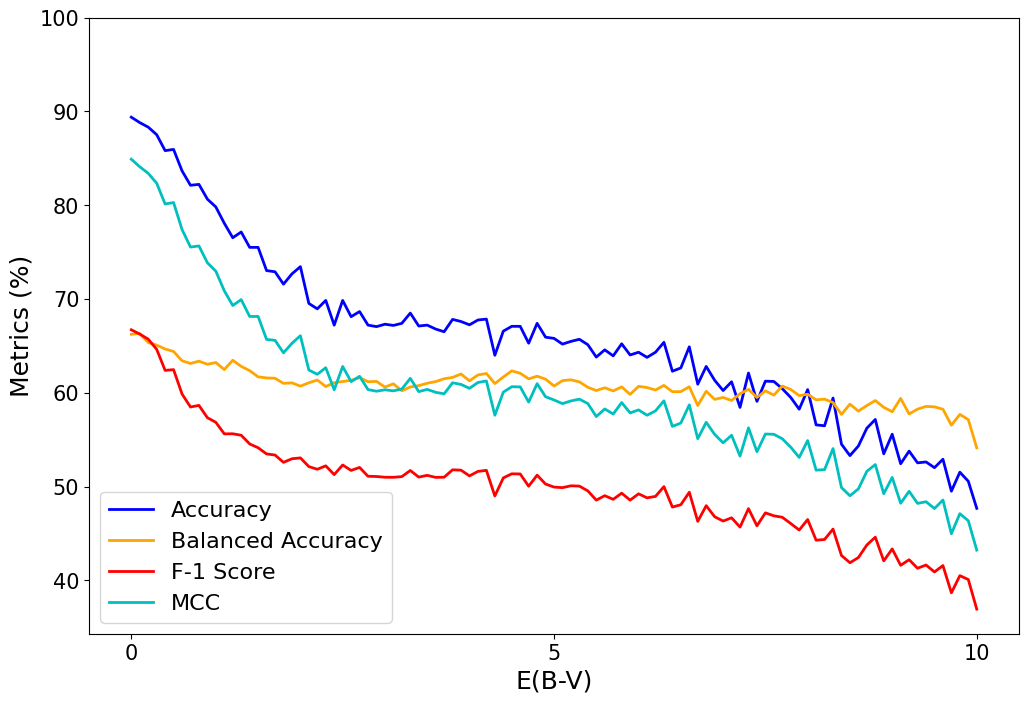

In [19]:
ebvs = np.linspace(0, 10, 101)
accuracys, balanced_accuracys, f1s = [], [], []
matthews_corrcoefs = []
for jj in range(0,101):
    df = df_default.iloc[jj::101, :]
    accuracys.append(accuracy_score(df.true_Class, df.Class))
    #print('accuracy for confident classifications:',accuracy_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
    balanced_accuracys.append(balanced_accuracy_score(df.true_Class, df.Class))
    #print('balanced accuracy for confident classifications:',balanced_accuracy_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
    f1s.append(f1_score(df.true_Class, df.Class, average='macro'))
    #print('f1_score for confident classifications:',f1_score(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class'], average='macro'))
    matthews_corrcoefs.append(matthews_corrcoef(df.true_Class, df.Class))
    #print('MCC conf:',matthews_corrcoef(df_default.loc[df_default.CT>=2, 'true_Class'], df_default.loc[df_default.CT>=2, 'Class']))
    #print('completeness:',len(df_default.loc[df_default.CT>=2])/len(df_default))
    #class_completeness = [len(df_default.loc[(df_default.CT>=2) & (df_default.true_Class==c)]) /len(df_default.loc[(df_default.true_Class==c)]) for c in class_labels ]
    #print('balanced completeness:',np.mean(class_completeness))

print(len(ebvs), len(accuracys))

fig, ax = plt.subplots(figsize=(12,8)) #plt.figure(figsize=(12, 8))
lw = 2

colors =  ['blue','orange','red','c','g','darkviolet','Aqua','yellow','olive']
#for line, label, color in zip([accuracys, balanced_accuracys, f1s, completeness, balanced_completeness,CSC_completeness,CSC_balanced_completeness], ['Accuracy', 'Balanced Accuracy', 'F1', 'Completeness', 'Balanced Completeness','CSC Completeness', 'CSC Balanced Completeness'],colors):
for line, label, color in zip([accuracys, balanced_accuracys, f1s, matthews_corrcoefs], ['Accuracy', 'Balanced Accuracy', 'F-1 Score', 'MCC', 'Completeness', 'Balanced Completeness'],colors):


    plt.plot(ebvs, line, color=color, lw=lw, label=label)

#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('E(B-V)',fontsize=18)
plt.ylabel('Metrics (%)',fontsize=18)
ax.set_yticks([0.4, 0.5, 0.6,  0.7, 0.8,0.9, 1])
ax.set_yticklabels(['40','50','60', '70', '80','90', '100'])
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower left",fontsize=16)

#plt.savefig('./figs/Confidence_CT.png',dpi=300)
plt.show() 


In [17]:
df_default = pd.read_csv(f'./data/LOO_test_TDv11162022_physicaloversample_results/0/classes.csv')
print(len(df_default)/101)

df = df_default.iloc[100::101, :]
print(len(df['name'].unique()))
#print(df)
for jj in range(0,101):
    print(jj)

3111.0
3111
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


## extracting the multi-wavelength properties of the training dataset, flaging the sources with optical/NIR/MIR counterparts

In [3]:
# extracting the multi-wavelength properties of the training dataset 
TD = pd.read_csv('../../files/CSC_TD_MW_remove.csv')
TD['Class'] = TD['Class'].replace({'NS_BIN':'LMXB'})
TD = prepare_cols(TD, cp_thres=0, TD=True, NS_MWdrop=False, STAR_classremove=['HM-STAR','LM-STAR','YSO']) # some filtering 
print(len(TD))

# flaging the sources with optical/NIR/MIR counterparts
TD['cp_flag'] = ''
for band, mark in zip([['Gmag','BPmag', 'RPmag'], ['Jmag','Hmag', 'Kmag'], ['W1mag', 'W2mag', 'W3mag']], ['g','t','w']):
    TD.loc[~TD[band].isna().all(axis=1), 'cp_flag']= TD.loc[~TD[band].isna().all(axis=1), 'cp_flag']+mark

print(TD['cp_flag'].value_counts())
#print(TD.groupby(['Class','cp_flag']).size())



Remove 21 [('LM-STAR', 1), ('YSO', 20)]
Final breakdown 2941 [('AGN', 1390), ('CV', 44), ('HM-STAR', 118), ('HMXB', 26), ('LM-STAR', 207), ('LMXB', 65), ('NS', 87), ('YSO', 1004)]
2941
gtw    1329
gw      542
gt      310
w       291
        237
t        96
tw       89
g        47
Name: cp_flag, dtype: int64


/tmp/ipykernel_2776/1332603590.py:2: DtypeWarning: Columns (314,315,316,317) have mixed types. Specify dtype option on import or set low_memory=False.
  TD = pd.read_csv('../../files/CSC_TD_MW_remove.csv')


In [4]:
df = pd.read_csv(f'./LOO_classes.csv')
print(len(df))

df_comb = pd.merge(df, TD[['name','cp_flag']], on='name')

2941


## Evaluation of TD sources that are missing optical/NIR/MIR counterparts (calculating performance metrics, confusion matrices)

In [6]:
for df, title, classes, band in zip([df_comb[~df_comb['cp_flag'].str.contains('g')].reset_index(drop=True), df_comb[~df_comb['cp_flag'].str.contains('t')].reset_index(drop=True), df_comb[~df_comb['cp_flag'].str.contains('w')].reset_index(drop=True)], ['nogaia', 'no2mass', 'nowise'], [['AGN','CV','LM-STAR','LMXB','NS','YSO'], ['AGN','CV','HM-STAR','LM-STAR','LMXB','NS','YSO'], ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']], ['optical',' NIR', 'MIR']):
    #class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO']
    print(len(df), 'sources are missing', band, 'counterparts.')
    #class_labels = df['Class'].unique()
    #print(class_labels)
    #print(df['true_Class'].unique())
    #df
    #title='cm'

    print('accuracy for all classifications:',accuracy_score(df.true_Class, df.Class))
    print('accuracy for confident classifications:',accuracy_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))
    print('balanced accuracy for all classifications:',balanced_accuracy_score(df.true_Class, df.Class))
    print('balanced accuracy for confident classifications:',balanced_accuracy_score(df.loc[df.CT>=2, 'true_Class'], df.loc[df.CT>=2, 'Class']))



    #CM = plot_confusion_matrix(df, title=f'recall {title}',classes=class_labels)
    #show(CM)
    conf_CM = plot_confusion_matrix_2fractions(df[df.CT>=2], title=f'confident recall {title}',classes=classes,count_fraction=True,df_all1 = df, df_all2 = df_comb)
    
    #conf_CM = plot_confusion_matrix_2fractions(df[df.CT>=2], title=f'confident recall {title}',classes=df.loc[df.CT>=2, 'Class'].unique(),count_fraction=True,df_all1 = df, df_all2 = df_comb)
    #CM_p = plot_confusion_matrix(df, title=f'precision {title}',classes=class_labels,cm_type='precision')
    #show(CM)
    conf_CM_p = plot_confusion_matrix_2fractions(df[df.CT>=2], title=f'confident precision {title}',classes=classes,cm_type='precision',count_fraction=True,df_all1 = df, df_all2 = df_comb)
    #export_png(CM, filename=f'./{title}.png')
    export_png(conf_CM, filename=f'./figures/{title}_conf.png')
    #export_png(CM_p, filename=f'./{title}_precision.png')
    export_png(conf_CM_p, filename=f'./figures/{title}_conf_precision.png')

713 sources are missing optical counterparts.
accuracy for all classifications: 0.7980364656381487
accuracy for confident classifications: 0.9493927125506073
balanced accuracy for all classifications: 0.5895341663830733
balanced accuracy for confident classifications: 0.7005763936623532
1117 sources are missing  NIR counterparts.
accuracy for all classifications: 0.855863921217547
accuracy for confident classifications: 0.9712643678160919
balanced accuracy for all classifications: 0.5182153686971132
balanced accuracy for confident classifications: 0.6459366384553418
690 sources are missing MIR counterparts.
accuracy for all classifications: 0.7536231884057971
accuracy for confident classifications: 0.9405034324942791
balanced accuracy for all classifications: 0.6233150575797252
balanced accuracy for confident classifications: 0.7691977098780196
